# Run Assay Conversion in Notebooks

In [1]:
import os
import re
import torch
import random
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
from scipy.stats import pearsonr

# for flex attention
import torch._dynamo
import torch.multiprocessing as mp 
torch._dynamo.config.suppress_errors = True

sc.set_figure_params(figsize=(4, 4))

from cellarium.ml.utilities.inference.cellarium_gpt_inference import \
    CellariumGPTInferenceContext

torch.set_default_dtype(torch.float64)

2025-04-11 16:04:07.919350: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-11 16:04:09.299901: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
ROOT_PATH = "/work/hdd/bbjr/mallina1/data/mb-ml-dev-vm"

ADATA_FP = '/work/hdd/bbjr/mallina1/data/mb-ml-dev-vm/data/pbmc_adata.h5ad'
REF_ADATA_FP = '/work/hdd/bbjr/mallina1/data/mb-ml-dev-vm/data/extract_0.h5ad'
OUT_ADATA_DIR = '/work/hdd/bbjr/mallina1/data/human_cellariumgpt_v2/assay_conversion'

GENE_INFO_PATH = os.path.join(ROOT_PATH, "gene_info", "gene_info.tsv")

# CHECKPOINT_PATH = "/work/hdd/bbjr/mallina1/cellarium/models/compute_optimal_checkpoints/epoch=1-step=28244.ckpt"
CHECKPOINT_PATH = "/work/hdd/bbjr/mallina1/cellarium/models/compute_optimal_checkpoints/epoch=6-step=63560.ckpt"
# CHECKPOINT_PATH = "/work/hdd/bbjr/mallina1/cellarium/models/compute_optimal_checkpoints/epoch=10-step=78917.ckpt"

DEVICE = 'cuda'

# set this according to the KEYS in assay_label_map
TARGET_ASSAY = '10x Chromium (v3)'
n_fixed_query_genes = 1024
cell_type = 'CD4+ T cell'

original_methods = ['10x Chromium (v2) A', '10x Chromium (v2) B', '10x Chromium (v3)',
                    'Drop-seq', 'Seq-Well', 'inDrops']

# Hard-coding mappings based on the PBMC dataset from Method -> assay and assay_ontology_term_id in CellariumGPT
assay_label_map = {
    "10x Chromium (v2) A": "10x 3' v2",
    "10x Chromium (v2) B": "10x 3' v2",
    "10x Chromium (v3)": "10x 3' v3",
    "Drop-seq": "Drop-seq",
    "Seq-Well": "Seq-Well",
    "inDrops": "inDrop"
}

assay_ontology_term_id_map = {
    "Seq-Well": "EFO:0008919",
    "10x 3' v3": "EFO:0009922",
    "Drop-seq": "EFO:0008722",
    "inDrop": "EFO:0008780",
    "10x 3' v2": "EFO:0009899"
}

In [3]:
ref_adata = sc.read_h5ad(REF_ADATA_FP)
val_adata = sc.read_h5ad(ADATA_FP)

# Obtain Cellarium var_names for subsampling later as well
ref_var_names = set(ref_adata.var_names)

# First subset the validation gene counts to those that show up in Cellarium training
val_adata = val_adata[:, val_adata.var_names.isin(ref_var_names)]

# Next subset by assays that we have relevant data for in Cellarium based on the assay_label_map
val_adata = val_adata[val_adata.obs.Method.isin(list(assay_label_map.keys()))]

# Finally re-order gene columns based on a fixed var_name list just in case
var_names = list(val_adata.var_names)
val_adata = val_adata[:, np.array(var_names)]

In [4]:
pd.crosstab(val_adata.obs.Method, val_adata.obs.CellType)

CellType,B cell,CD4+ T cell,CD14+ monocyte,CD16+ monocyte,Cytotoxic T cell,Dendritic cell,Megakaryocyte,Natural killer cell,Plasmacytoid dendritic cell,Unassigned
Method,,,,,,,,,,
10x Chromium (v2) A,288,550,640,102,1174,55,221,166,26,0
10x Chromium (v2) B,388,908,379,73,954,33,212,263,12,0
10x Chromium (v3),346,960,354,98,962,38,270,194,0,0
Drop-seq,1405,2061,357,198,1978,46,27,484,28,0
Seq-Well,527,566,1255,0,1278,37,38,0,26,46
inDrops,1045,1111,2038,244,1664,148,145,147,42,0


In [5]:
# # Subset to cells where nUMI falls in between [min_umis, max_umis], inclusive
# umi_qc_lower_mask = val_adata.obs['nUMI'].astype(int) >= args.min_umis
# umi_qc_upper_mask = val_adata.obs['nUMI'].astype(int) <= args.max_umis
# umi_qc_mask = umi_qc_lower_mask | umi_qc_upper_mask

# val_adata = val_adata[umi_qc_mask]

# Finally re-order gene columns based on a fixed var_name list just in case
# var_names = list(val_adata.var_names)
# val_adata = val_adata[:, np.array(var_names)].copy()

# ig_mask = np.array(val_adata.var.gene_symbols.str.startswith('IG'))
# val_adata = val_adata[:, ~ig_mask].copy()
# var_names = list(val_adata.var_names)

sc.pp.highly_variable_genes(val_adata, flavor='seurat_v3', n_top_genes=n_fixed_query_genes)
val_adata = val_adata[:, val_adata.var['highly_variable']].copy()

/u/mallina1/envs/torch_jax2/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:172: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


In [6]:
# Optional subsetting by method and cell type
# val_adata = val_adata[val_adata.obs.Method == '10x Chromium (v3)']
val_adata = val_adata[val_adata.obs.CellType == 'CD4+ T cell']

## Load inference context

In [7]:
ctx = CellariumGPTInferenceContext(
    cellarium_gpt_ckpt_path=CHECKPOINT_PATH,
    ref_adata_path=REF_ADATA_FP,
    gene_info_tsv_path=GENE_INFO_PATH,
    device=DEVICE,
    attention_backend="mem_efficient"
)
# ctx.gpt_pipeline.model = ctx.gpt_pipeline.model.double()

In [8]:
processed_val_adata = val_adata.copy()

processed_val_adata.obs['assay'] = val_adata.obs['Method'].map(assay_label_map)
processed_val_adata.obs['assay_ontology_term_id'] = processed_val_adata.obs['assay'].map(assay_ontology_term_id_map)
processed_val_adata.obs['suspension_type'] = 'cell'
processed_val_adata.obs['total_mrna_umis'] = processed_val_adata.obs.nUMI.astype(np.int64)

# Get random values for cell_type, tissue, disease, sex, and development_stage from ref_adata
# since we are going to mask all of this anyway, just needed to have a valid category in the
# get_tokens_from_adata function.

processed_val_adata.obs['cell_type_ontology_term_id'] = None
processed_val_adata.obs['tissue_ontology_term_id'] = None
processed_val_adata.obs['disease_ontology_term_id'] = None
processed_val_adata.obs['sex_ontology_term_id'] = None
processed_val_adata.obs['development_stage_ontology_term_id'] = None

In [9]:
processed_val_adata.obs

,NAME,nGene,nUMI,percent.mito,Cluster,CellType,Experiment,Method,assay,assay_ontology_term_id,suspension_type,total_mrna_umis,cell_type_ontology_term_id,tissue_ontology_term_id,disease_ontology_term_id,sex_ontology_term_id,development_stage_ontology_term_id
960,pbmc1_10x_v2_A_AACCGCGCAATCTACG,1031,2730,0.0296703296703297,2,CD4+ T cell,pbmc1,10x Chromium (v2) A,10x 3' v2,EFO:0009899,cell,2730,None,None,None,None,None
961,pbmc1_10x_v2_A_AACCGCGTCATCATTC,833,1921,0.0661114003123373,2,CD4+ T cell,pbmc1,10x Chromium (v2) A,10x 3' v2,EFO:0009899,cell,1921,None,None,None,None,None
972,pbmc1_10x_v2_A_AAGCCGCTCTAACCGA,1099,3419,0.0295408014039193,2,CD4+ T cell,pbmc1,10x Chromium (v2) A,10x 3' v2,EFO:0009899,cell,3419,None,None,None,None,None
1095,pbmc1_10x_v2_A_AGGTCCGGTTAAGATG,926,2479,0.0399354578459056,2,CD4+ T cell,pbmc1,10x Chromium (v2) A,10x 3' v2,EFO:0009899,cell,2479,None,None,None,None,None
1120,pbmc1_10x_v2_A_ATCATCTAGTGTCCAT,1066,3260,0.0306748466257669,2,CD4+ T cell,pbmc1,10x Chromium (v2) A,10x 3' v2,EFO:0009899,cell,3260,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29959,pbmc2_inDrops_1_GTCCGTCA.TTATGCGA.GTTTGTTT,585,1128,0.0780141843971631,1,CD4+ T cell,pbmc2,inDrops,inDrop,EFO:0008780,cell,1128,None,None,None,None,None
29983,pbmc2_inDrops_1_TAATGTGG.TTATGCGA.GGATAAAG,757,1286,0.0419906687402799,1,CD4+ T cell,pbmc2,inDrops,inDrop,EFO:0008780,cell,1286,None,None,None,None,None
29989,pbmc2_inDrops_1_TACGCGAG.TTATGCGA.TGTTCCAG,592,1216,0.078125,1,CD4+ T cell,pbmc2,inDrops,inDrop,EFO:0008780,cell,1216,None,None,None,None,None
29991,pbmc2_inDrops_1_TAGATCAA.TTATGCGA.TTCGTTCC,552,1143,0.0927384076990376,1,CD4+ T cell,pbmc2,inDrops,inDrop,EFO:0008780,cell,1143,None,None,None,None,None


In [10]:
metadata_prompt_dict = {
    "cell_type": False,
    "tissue": False,
    "disease": False,
    "sex": False,
    "development_stage": False
}

# target_assay = '10x Chromium (v3)
target_assay = TARGET_ASSAY
fixed_query_genes = processed_val_adata.var_names

# sample_indices = random.sample(range(len(var_names)), n_fixed_query_genes)
# sample_indices.sort()
# fixed_query_genes = [var_names[i] for i in sample_indices]  

adata_fixed_genes_original = processed_val_adata[:, np.array(fixed_query_genes)].copy()
adata_fixed_genes_converted = adata_fixed_genes_original.copy()
adata_fixed_genes_means = adata_fixed_genes_original.copy()

batch_size = 128
X_lil = adata_fixed_genes_converted.X.tolil()
X_lil_means = adata_fixed_genes_means.X.tolil()

batch_obs_idx = []
batch_query_total_mrna_umis = []
skipped_row = []

orig_raw = []
converted_raw = []
means_raw = []

pbar = tqdm(total=adata_fixed_genes_original.shape[0])
for val_obs_idx in range(0, adata_fixed_genes_original.shape[0]):
    pbmc_cell_type = adata_fixed_genes_original.obs.iloc[val_obs_idx].CellType

    # UMIs by cell type and target assay in order to sample from in conversion
    pbmc_umis = val_adata[val_adata.obs.CellType == pbmc_cell_type]
    pbmc_umis = pbmc_umis[pbmc_umis.obs.Method == target_assay]

    # Use the global nUMI in the adata to sample from
    pbmc_umis = pbmc_umis.obs.nUMI.to_numpy().astype(int)

    if len(pbmc_umis) == 0:
        skipped_row.append(True)
        pbar.update(1)
        continue

    orig_raw.append(adata_fixed_genes_original.X[val_obs_idx])

    # query_total_mrna_umis = np.random.choice(pbmc_umis, size=(n_fixed_query_genes,), replace=True)
    # query_total_mrna_umis = np.array(query_total_mrna_umis, dtype=np.int64)
    query_total_mrna_umis = np.array([np.median(pbmc_umis)] * n_fixed_query_genes).astype(int)

    batch_query_total_mrna_umis.append(query_total_mrna_umis[None, :])
    batch_obs_idx.append(val_obs_idx)
    skipped_row.append(False)

    if len(batch_obs_idx) < batch_size and val_obs_idx != adata_fixed_genes_original.shape[0] - 1:
        continue

    batch_query_total_mrna_umis = np.concatenate(batch_query_total_mrna_umis, axis=0)
    query_assay = assay_label_map[target_assay]
    query_assay_ontology_term_id = assay_ontology_term_id_map[query_assay]

    with torch.no_grad():
        tokens_dict, context_indices = ctx.generate_tokens_from_adata(adata_fixed_genes_original, 
                                                                      obs_index=batch_obs_idx, 
                                                                      query_var_names=fixed_query_genes,
                                                                      metadata_prompt_masks_dict=metadata_prompt_dict,
                                                                      query_total_mrna_umis=batch_query_total_mrna_umis,
                                                                      query_assay_ontology_term_id=query_assay_ontology_term_id)
        

        gene_logits_nqk = ctx.get_gene_value_logits_from_tokens(tokens_dict,
                                                                context_indices,
                                                                max_counts=None)
        
        gene_marginal_mean_nq, _ = ctx.calculate_gene_mean_std_from_logits(gene_logits_nqk,
                                                                           gene_logits_nqk.shape[-1],
                                                                           use_logsumexp=True)

        dist = torch.distributions.categorical.Categorical(logits = gene_logits_nqk)
        converted_raw.append(dist.sample().cpu())
        means_raw.append(gene_marginal_mean_nq.cpu())
        for idx_in_batch, idx_in_adata in enumerate(batch_obs_idx):
            dist = torch.distributions.categorical.Categorical(logits = gene_logits_nqk[idx_in_batch].squeeze())
            row_sample = dist.sample()
            X_lil[idx_in_adata,:] = row_sample.cpu()
            X_lil_means[idx_in_adata,:] = gene_marginal_mean_nq[idx_in_batch].cpu().numpy().squeeze()

    pbar.update(len(batch_obs_idx))
    batch_obs_idx = []
    batch_query_total_mrna_umis = []

orig_raw = [x.todense() for x in orig_raw]
orig_raw = np.concatenate(orig_raw, axis=0)
converted_raw = torch.cat(converted_raw, dim=0).numpy()
means_raw = torch.cat(means_raw, dim=0).numpy()

adata_fixed_genes_converted.X = X_lil.tocsr()
adata_fixed_genes_means.X = X_lil_means.tocsr()

skipped_row = np.array(skipped_row).astype(bool)

adata_fixed_genes_original = adata_fixed_genes_original[~skipped_row]
adata_fixed_genes_converted = adata_fixed_genes_converted[~skipped_row]
adata_fixed_genes_means = adata_fixed_genes_means[~skipped_row]

  0%|                                                                                                                                                    | 0/6156 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6156/6156 [06:02<00:00, 16.98it/s]

torch.float32


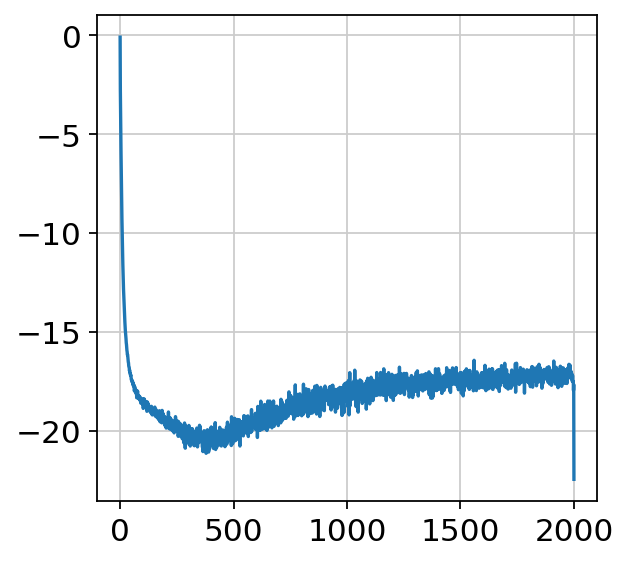

In [11]:
print(gene_logits_nqk.dtype)
plt.plot(gene_logits_nqk[10][0].double().cpu())
plt.show()

In [12]:
print(orig_raw.shape, converted_raw.shape, means_raw.shape)
print(orig_raw.sum(0).shape)

(6156, 1024) (6156, 1024) (6156, 1024)
(1, 1024)


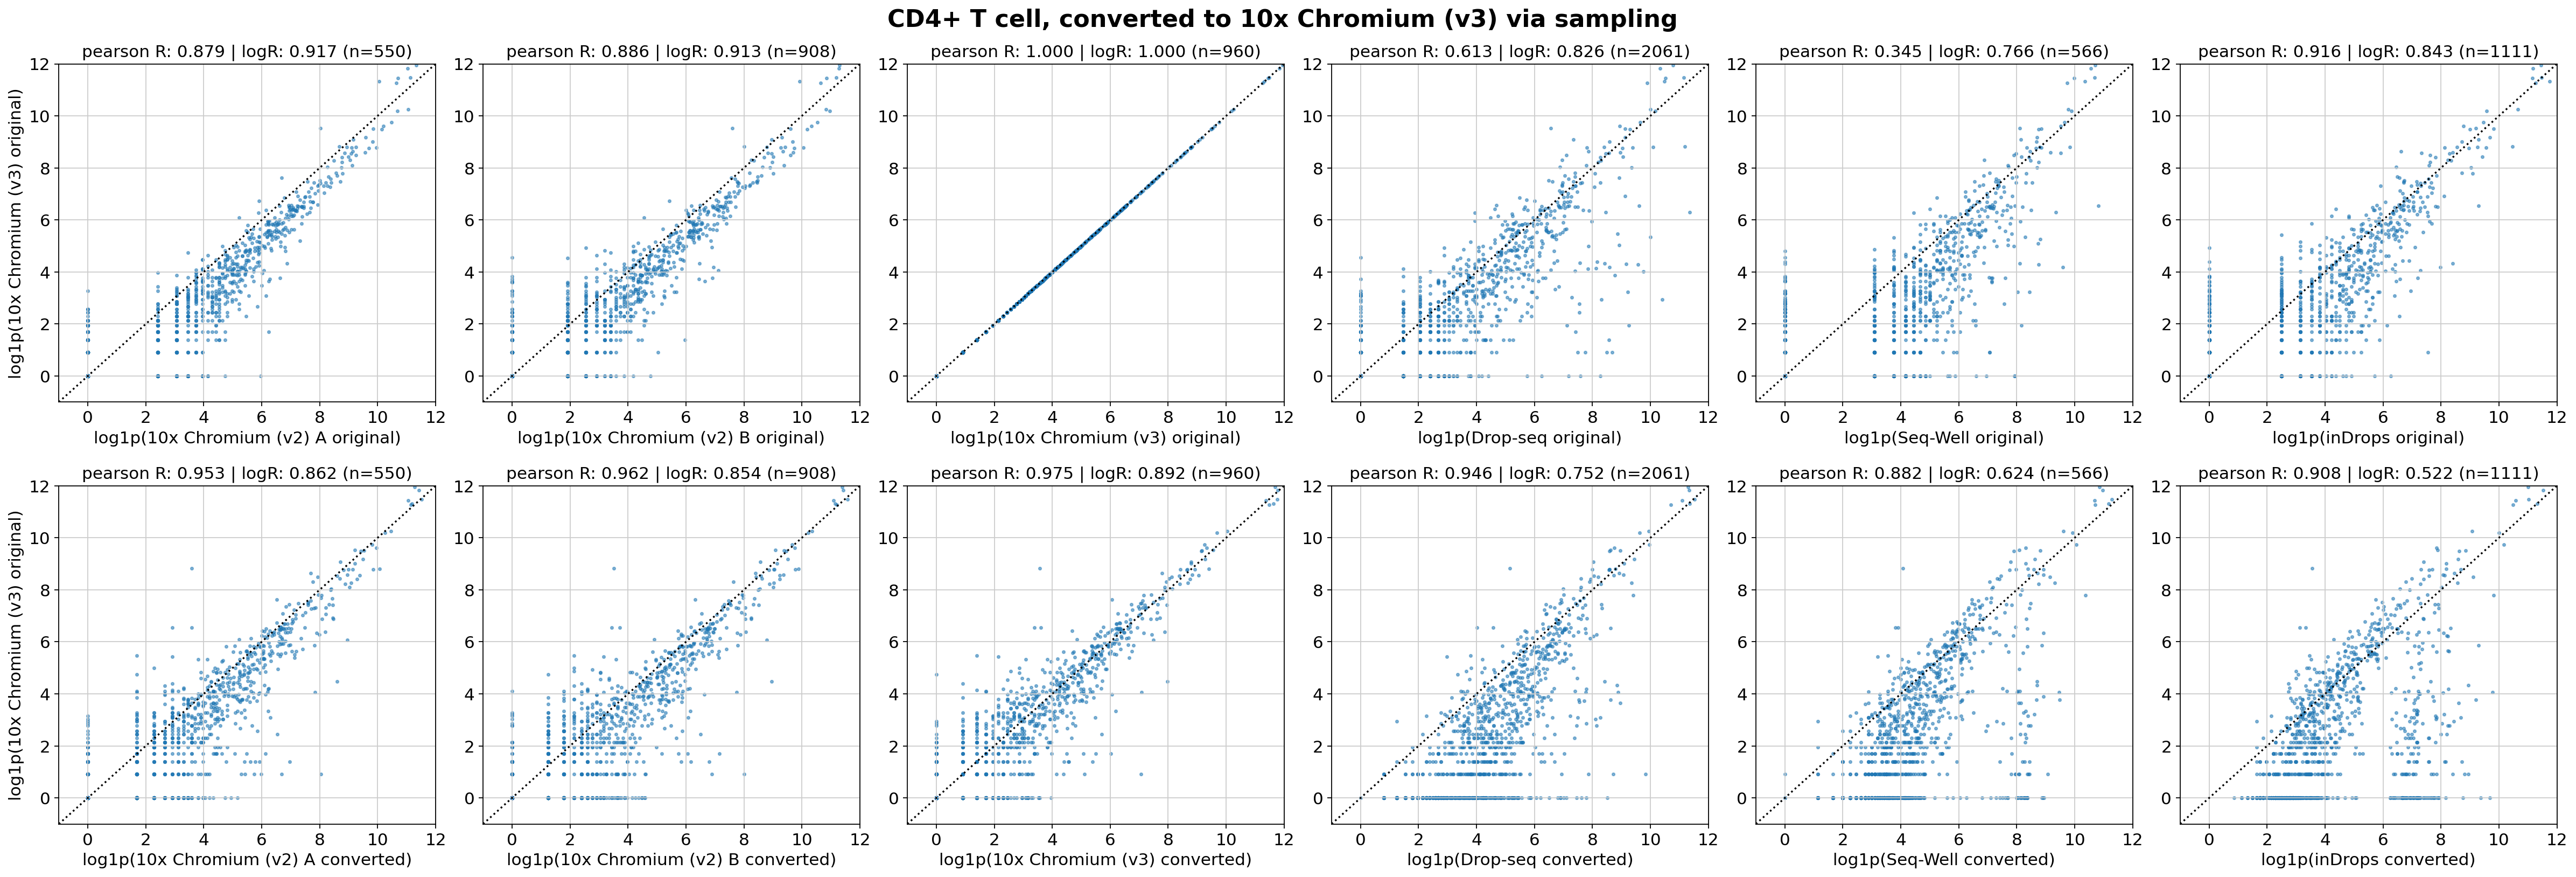

In [13]:
# Select cell type
ct_original = adata_fixed_genes_original[adata_fixed_genes_original.obs.CellType == cell_type]
ct_converted = adata_fixed_genes_converted[adata_fixed_genes_converted.obs.CellType == cell_type]
ct_converted_means = adata_fixed_genes_means[adata_fixed_genes_means.obs.CellType == cell_type]

# Include target assay in the comparison
assays_to_compare = original_methods  # Now includes `target_assay`

# Prepare plot grid
num_assays = len(assays_to_compare)
fig, axes = plt.subplots(2, num_assays, figsize=(5 * num_assays, 10))

for idx, assay in enumerate(assays_to_compare):
    cell_count = (ct_original.obs.Method == assay).sum()
    assay_idx = ct_original.obs.Method == assay
    target_assay_idx = ct_original.obs.Method == target_assay

    a1_X_g = np.array(orig_raw[assay_idx].sum(0)).squeeze()
    a2_X_g = np.array(orig_raw[target_assay_idx].sum(0)).squeeze()
    a3_X_g = np.array(converted_raw[assay_idx].sum(0)).squeeze()

    # Extract and normalize counts
    # a1_X_g = np.array(ct_original[ct_original.obs.Method == assay].X.sum(0)).squeeze()
    # a2_X_g = np.array(ct_original[ct_original.obs.Method == target_assay].X.sum(0)).squeeze()
    # a3_X_g = np.array(ct_converted[ct_converted.obs.Method == assay].X.sum(0)).squeeze()

    a1_X_g = a1_X_g / np.sum(a1_X_g) * 1e6  # Normalize to TPM
    a2_X_g = a2_X_g / np.sum(a2_X_g) * 1e6
    a3_X_g = a3_X_g / np.sum(a3_X_g) * 1e6

    # Apply log1p transformation
    log_a1_X_g = np.log1p(a1_X_g)
    log_a2_X_g = np.log1p(a2_X_g)
    log_a3_X_g = np.log1p(a3_X_g)

    # Compute Pearson correlations
    r_linear_orig, _ = pearsonr(a1_X_g, a2_X_g)
    r_log_orig, _ = pearsonr(log_a1_X_g, log_a2_X_g)
    
    r_linear_conv, _ = pearsonr(a3_X_g, a2_X_g)
    r_log_conv, _ = pearsonr(log_a3_X_g, log_a2_X_g)

    # Top row: Original assay vs. Target assay (Original) in log space
    ax = axes[0, idx]
    ax.scatter(log_a1_X_g, log_a2_X_g, alpha=0.5, s=5)
    ax.set_title(f"pearson R: {r_linear_orig:.3f} | logR: {r_log_orig:.3f} (n={cell_count})")
    ax.set_xlabel(f"log1p({assay} original)")
    ax.axline((0, 0), slope=1, linestyle=':', c='black')
    if idx == 0:
        ax.set_ylabel(f"log1p({target_assay} original)")

    # Bottom row: Converted assay vs. Target assay (Original) in log space
    ax = axes[1, idx]
    ax.scatter(log_a3_X_g, log_a2_X_g, alpha=0.5, s=5)
    ax.set_title(f"pearson R: {r_linear_conv:.3f} | logR: {r_log_conv:.3f} (n={cell_count})")
    ax.set_xlabel(f"log1p({assay} converted)")
    ax.axline((0, 0), slope=1, linestyle=':', c='black')
    if idx == 0:
        ax.set_ylabel(f"log1p({target_assay} original)")

for ax in axes.flat:
    ax.set_xlim(-1, 12)
    ax.set_ylim(-1, 12)

plt.tight_layout()
plt.suptitle(f"{cell_type}, converted to {target_assay} via sampling", fontsize=20, fontweight='bold', y=1.02)

plt.show()

In [14]:
# formatted = datetime.now().strftime("%Y_%m_%d_%H_%M")

# filename = f'{formatted}_convert_to_{"_".join(target_assay.split())}'
# clean_filename = re.sub(r'[^a-zA-Z0-9._-]', '', filename)

# target_assay_out_dir = os.path.join(OUT_ADATA_DIR, clean_filename)
# os.makedirs(target_assay_out_dir)

# results_fp1 = os.path.join(target_assay_out_dir, f'original.h5ad')
# results_fp2 = os.path.join(target_assay_out_dir, f'converted.h5ad')
# results_fp3 = os.path.join(target_assay_out_dir, f'converted_means.h5ad')

# for adata in [adata_fixed_genes_original, adata_fixed_genes_converted, adata_fixed_genes_means]:
#     del adata.obs['cell_type_ontology_term_id']
#     del adata.obs['tissue_ontology_term_id']
#     del adata.obs['disease_ontology_term_id']
#     del adata.obs['sex_ontology_term_id']
#     del adata.obs['development_stage_ontology_term_id']

# sc.write(results_fp1, adata_fixed_genes_original)
# sc.write(results_fp2, adata_fixed_genes_converted)
# sc.write(results_fp3, adata_fixed_genes_means)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6156/6156 [06:20<00:00, 16.98it/s]